# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [45]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [46]:
# TODO: Total number of records
n_records = len(data['income'])

# TODO: Number of records where individual's income is more than $50,000
seriesIncome = data['income'].value_counts()
n_greater_50k = seriesIncome.get('>50K')

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = seriesIncome.get('<=50K')

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (float(n_greater_50k)/float(n_records))*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

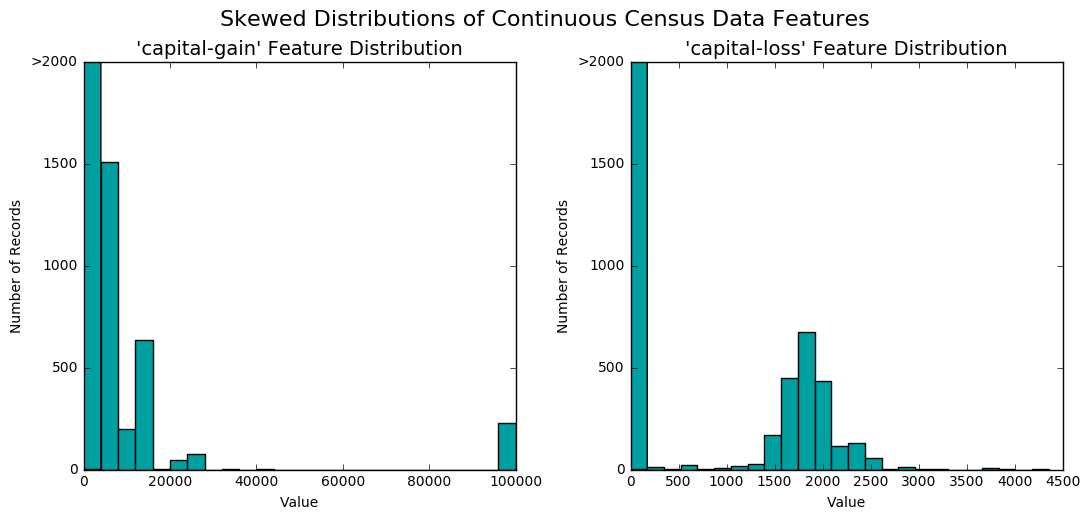

In [47]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

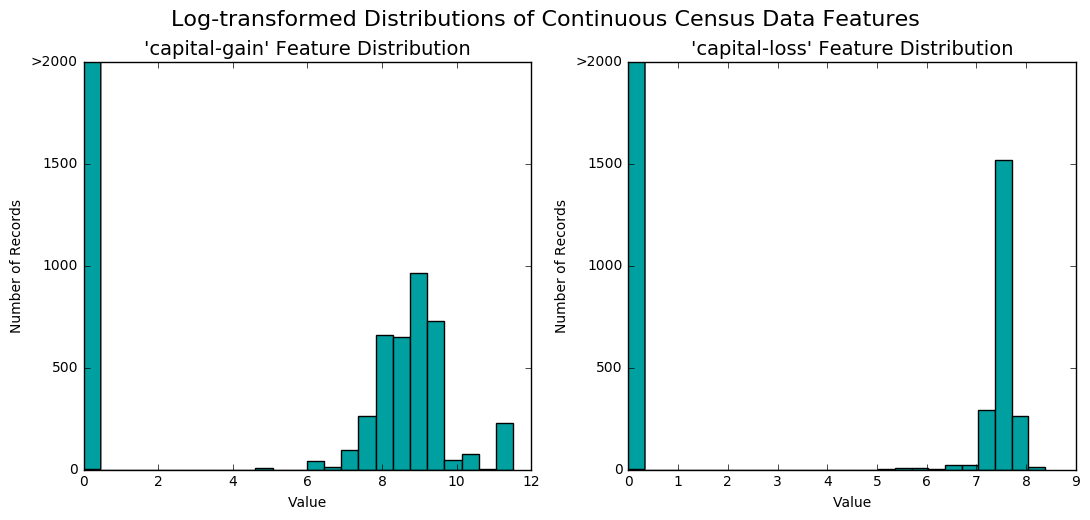

In [48]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [49]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [50]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
categorical = ['workclass','education_level','marital-status','occupation','relationship','race','sex','native-country']
features = pd.get_dummies(features_raw,columns=categorical)
#features = None

# TODO: Encode the 'income_raw' data to numerical values
income = income_raw.apply(lambda x: 0 if x=='<=50K' else 1)
#income = None

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print encoded
#display(income.head(n = 1))

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [51]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *UdacityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would is appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *UdacityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *UdacityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [52]:
# TODO: Calculate accuracy
# tp=True Positives, tn=True Negatives, fp = False Positives, fn = False Negatives
tp = float(n_greater_50k)
fp = float(n_at_most_50k)
tn = 0.0
fn = 0.0
accuracy = tp/(tp+fp+tn+fn)
#accuracy = 0.2478

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = 0.5
precision= tp/(tp+fp)
recall = tp/(tp+fn)
fscore=((1+beta*beta)*precision*recall)/((beta*beta*precision)+recall)
#fscore = 0.2917

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


###  Supverised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent Classifier (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **


In my opinion, the three supervised learning models, that are appropriate for this classification problem are:
1. Logistic Regression
2. Ensemble Methods (specifically, AdaBoost)
3. Decision Trees

*Logistic Regression* : Is a good classification tool to fit large amounts of data quickly and to get a feel for the data. It is simple algorithm that can help guage if the classification can be done using a simple straight line as the decision boundary between the two classes. Some of the advantages of Logistic Regression are that : (1) Its the first pick for modelling when the number of featues are greater than the samples available, because it can do a pretty good job of determining the decision boundary even with small sets of data. (2) It is easy to understand why the model decided on a set of coefficients, when the number of features are low.
Some of the practical applications of Linear models are in predicting the class around well clustered data like given a set of features and the class the customer belongs to, predict which class a new unknown incoming customer would belong to, given we know the details of the features that define this customer (https://www.ibm.com/support/knowledgecenter/en/SS3RA7_15.0.0/com.ibm.spss.modeler.help/discriminant_node_general.htm)

Some of the weaknesses of the Logistic Regression are that they tend to perform worse than other models in lower-dimensional spaces. Also when the number of features in the data increases, and specifically when the features are correlated, it is hard to see and explain why the model picks the coefficients it picks.

The reason why Logistic Regression seems like a good base candidate for this set of data, is that the features have very low data variablity in them. Also, the importance of each of the features are not readily visible. The accuracy of logistic regression will set up a base from which we can work with other models to attain better accuracy.

*AdaBoost* : is an Ensemble method that picks up a set of "weak learners" on the training feature set and assigns weights to the "weak learners" based on how well they classify the given data set.
Classic example of Adaboost is the Face Detection systems (https://www.vision.caltech.edu/html-files/EE148-2005-Spring/pprs/viola04ijcv.pdf), where the features are rectangles and the Adaboost algorithm is used to quickly reject negative windows while giving higher weights to the successful features.
Some of the advantages of the Adaboost model is that, with very less number of parameters, tuning the model can achieve classification levels similar to SVMs. One has to only tune (1) which weak classifier might work best to solve the given classification problem; (2) the number of boosting rounds that should be used during the training phase
Some of the disadvantages with Adaboost model is that : AdaBoost can be sensitive to noisy data and outliers. In some problems, however, it can be less susceptible to the overfitting problem than most learning algorithms.

The reason why Adaboost seems like a good candidate for modelling this data set is because, the data has been cleaned to remove noisy data and the features don't take up a wide range of values, and by just skimming the data it seems like that a group of weak classifiers, with proper weighting based on their accuracy will do a good job in fitting this data.


*Decision Trees* : Are used extensively for a variety of decision making in the industry. Some notable examples are 
- buy vs build vs no-change decisions during software upgrades (http://www.brighthubpm.com/risk-management/48360-using-a-decision-tree-to-calculate-expected-monetary-value/)
- strategic decision making, like in the example when Gerber had to make a decision whether to continue using the plastic known as poly-vinyl chloride or, more commonly, PVC or to switch to alternatives (https://gbr.pepperdine.edu/2010/08/how-gerber-used-a-decision-tree-in-strategic-decision-making/)


Some of the *strengths* of the Decision Tree are that it picks the features that have the maximum information gain over those that have lower information gain at each level of the tree. Hence, it tends to have good splits right at the top. As a result if the incoming data is good, we could end up with short trees. Short trees are also easy to explain in layman's terms and hence don't tend to be as much of a "black box" classifier as the other classifiers tend to be.

Some of the *weaknesses* of the Decision Tree is that it tends to overfit the training data. If the incoming data has outliers, the decision tree creates extra branches to fit these outliers. This leads to both lower accuracy on the testing set as well to lengthier trees, that are both hard to explain in lay man's terms and also bulkier to store and work with.

The reason why decision trees seem like a good fit for this data, is because of my domain knowledge of the given data and the low variability of the features. It seems like some of the features, like education_level and sex, might be more important to proper prediction of the income than say age. And a decision tree will do a good job in identifying these important features upfront on the tree and use the lesser important features way down in the tree.

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [53]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    from sklearn.metrics import accuracy_score
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    from sklearn.metrics import fbeta_score
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Dependent on which algorithms you chose, the following implementation may take some time to run!

DecisionTreeClassifier trained on 452 samples.
DecisionTreeClassifier trained on 4522 samples.
DecisionTreeClassifier trained on 45222 samples.
AdaBoostClassifier trained on 452 samples.
AdaBoostClassifier trained on 4522 samples.
AdaBoostClassifier trained on 45222 samples.
LogisticRegression trained on 452 samples.
LogisticRegression trained on 4522 samples.
LogisticRegression trained on 45222 samples.


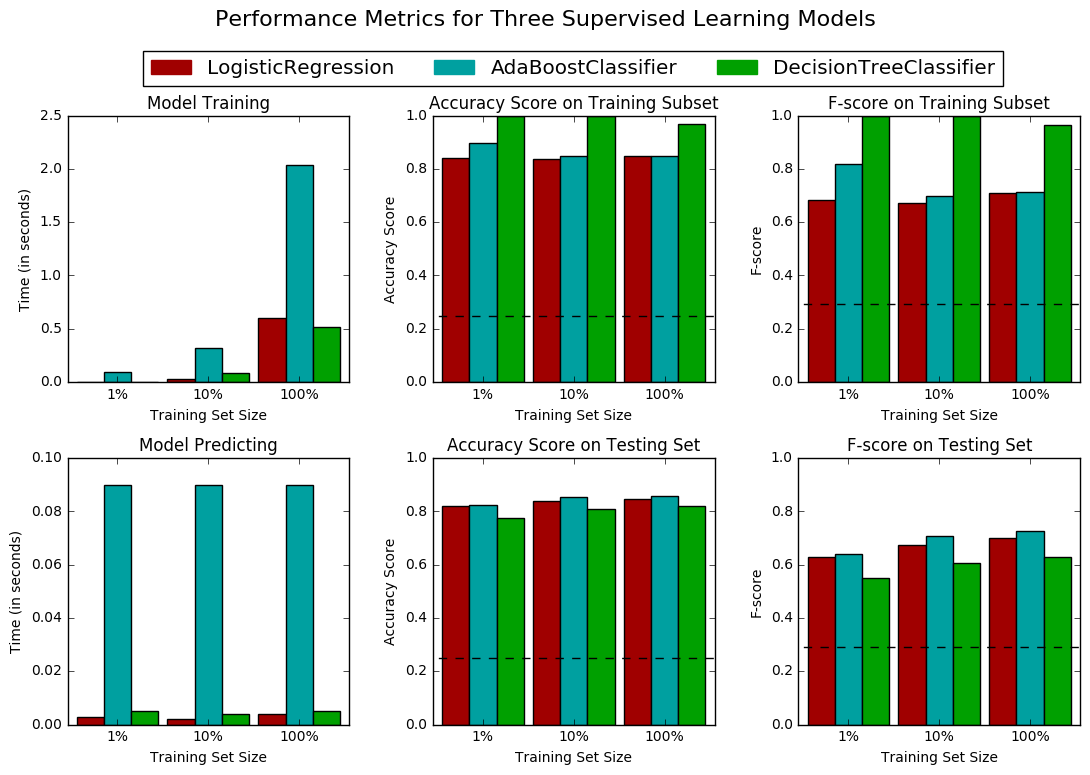

In [55]:
# TODO: Import the three supervised learning models from sklearn

# TODO: Initialize the three models
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
clf_A = DecisionTreeClassifier(random_state=0)
clf_B = AdaBoostClassifier(random_state=0)
clf_C = linear_model.LogisticRegression()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
#from sklearn.model_selection import ShuffleSplit
samples_1 = int(0.01*len(features))
samples_10 = int(0.1*len(features))
samples_100 = int(len(features))

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the census data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

The best model for identifying the individuals that make more than \$50,000 is to use the AdaBoost classifier. As shown in the above graphs, it did a very good job in terms of accuracy and F-score compared to those of Logistic Regression and the Decision Tree based model. The fact that the Adaboost uses weighted hyptheses to determine the class of a data point helps in this case, because intutively, different features provide different weights to whether a person makes more than \$50,000 or not. Meaning, the fact that the person is male could account for 20% of the reason for him making more than \$50,000 and the fact that a person has x amount of education accounts for another 24% of the reason why the person makes more than \$50,000. The Adaboost model is capable of learning these weights during the fitting stage of the data, and use these weighted hypotheses during the prediction of unseen data.

The AdaBoost classifier is good at classifying data that is low in noise. Since the census data provided here has been preprocessed to remove the noisy data, it is safe to use Adaboost. Although the Adaboost classifier does take more time during the learning time compared to the other models, and the time it takes increases with the number of training data, the higher accuracy rates it achieves makes it a good choice. Also notice that the prediction time is constant and does not increase with the data to predict. So it is ideal in our case where we dont have to retrain the model often, as the census data comes out only once every 10 years.

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

During the learning stage of the Adaboost model, the algorithm, makes a hypothesis about the learning data and tries to fit the data against the hypothesis. If it finds data points not fitting that hypothesis, it calculates the weights it needs to assign these points and finds the next hypothesis based on the weighted data points from the previous step. It keeps doing this till all the data points are classified right. And the way it decides which hypothesis to use is based on a very simple concept of a weak learner. A weak learner is any hypothesis that is better at predicting the output of a given data at a rate greater than pure chance, that is, at a rate better than 50%. By using the mechanism of weighted hypothesis, the model is capable of assigning the hypotheses that do a good job at classifying the data a higher weight than the hypotheses that don't do as well in predicting the data.

To ensure that the trained model is accurate, the data it uses for training is expected to be of reasonable quality, with noisy data removed to ensure both that the time to learn is optimally used as well as the trained model is not exteremely bulky, in order to accomodate the noisy data.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [42]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries

# TODO: Initialize the classifier
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(random_state=0)

# TODO: Create the parameters list you wish to tune
parameters = {'n_estimators':(50,100,150,200), 'learning_rate':(1.0, 0.5, 0.75), 'algorithm':('SAMME','SAMME.R')}

# TODO: Make an fbeta_score scoring object
from sklearn.metrics import fbeta_score, make_scorer
scorer = make_scorer(fbeta_score, beta=0.5)
#scorer = None

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
from sklearn.grid_search import GridSearchCV
grid_obj = GridSearchCV(clf, parameters, scoring=scorer)
#grid_obj = None

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
from sklearn.metrics import accuracy_score
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8651
Final F-score on the testing data: 0.7396


### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |       0.2478        |      0.8576       |      0.8651     |
| F-score        |       0.2917        |      0.7246       |      0.7396     |


**Answer: **

The optimized model's accuracy and the F-score are better than the accuracy and the F-score of the unoptimzed model. The GridSearchCV is capable of running the scoring on the model with different parameters and come up with the most optimal set of values for the parameters. In the case of the sklearn implementation of the Adaboost model, the parameters of consideration are base_estimator, n_estimators, learning_rate and the algorithm. The base_estimator can take any algorithm from which the boosted ensemble is built. Since the out of the box implementation of Adaboost provides only the DecisionTreeClassifier, I did not provide options for the GridSearchCV to work on this parameter. I applied different values on the other parameters like n_estimators, learning_rate and the algorithm to get the GridSearchCV to return the best values for these parameters.

The accuracy score of the optimized model is more than 3 times better than the benchmarck predictor, meaning using the supervised optimized model we could predict the class of a data point at a rate of 86% compared to a rate of 25% with just saying naively that all the predictions are of one class without looking at their feature values.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

Looking only at the data, it seems like the important features that would determine whether a person would make more than \$50,000 would be the 
1. education
2. occuption
3. sex
4. workclass
5. capital-gain

I would choose the above set of features to be the ones of greater importance and rank them as I did above, because of the domain knowledge I possess about the said data set. I know from my previous knowledged that a higher educated person would make more money, a better occupation would make more money, males make more money than females, certain workclasses make more money than others and that capital-gain is extra income that supplements a salaried or a business income.

### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

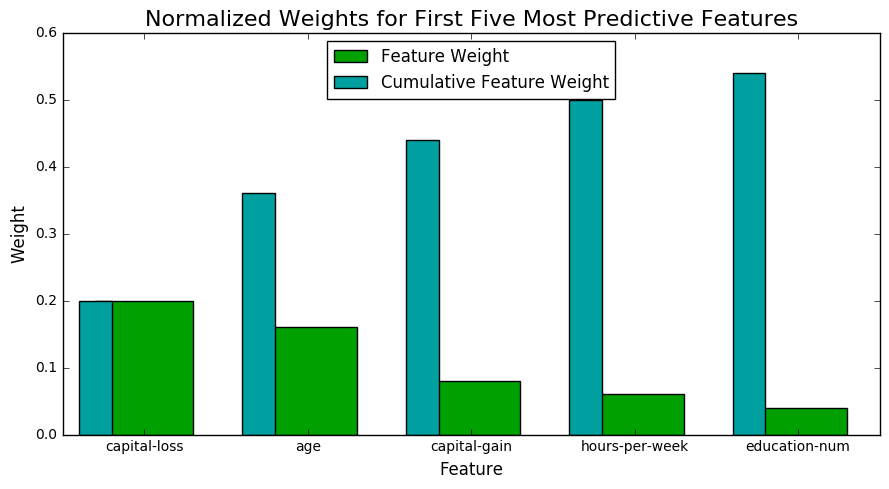

In [43]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = AdaBoostClassifier(random_state=0).fit(X_train, y_train)

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

I chose :
1. education
2. occuption
3. sex
4. workclass
5. capital-gain 

and the model selected these :
1. capital-loss
2. age
3. capital-gain
4. hours-per-week
5. education-num

There are differences with what I chose as important features and what the model chose as important features and even the sequencing of their importances. I predicted that the occupation, workclass and sex would play a more important role as features important to predicting the class but the model chose  age, hours-per-week and capital-loss. I think that is because of the DecisionTreeClassifier that the model uses as its underlying base_estimator classifier. Decision trees tend pick features that best separate the data best, that is, a feature hypothesis that has the most information gain at any specific stage of classification. On the other hand, I was using my base intuition of how much a feature would impact the outcome, solely based on prior external domain knowledge.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [44]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8651
F-score on testing data: 0.7396

Final Model trained on reduced data
------
Accuracy on testing data: 0.8385
F-score on testing data: 0.6920


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

The Accuracy and the F-score of reduced data are definitely very close to the Accuracy and F-score of the full training set, although they are a bit on the lower end. If training time was a factor, I would definitely consider using the reduced data as the training set. Especially, because the model I chose, Adaboost, tends to take time propotional to the data it is training on during the training phase.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.